# ENVIRONMENT

In [1]:
import os
import acquire
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ACQUIRE

In [2]:
df1 = acquire.read_data('data08.csv')
df2 = acquire.read_data('data10.csv')
df3 = acquire.join_data('data08.csv', 'data10.csv')

In [3]:
df1.head()

,CASEID,MARITAL,B1AGE,AGEDISP,RACER,SEX_N,AGE_N,RACE_N,HSPNC_N,OTHERR_N,...,REASONR5,CHILDCB,L28KIDSN,KIDSNUM,FOSTER_N,KIDLIV_N,KIDIV2_N,DECEASED,STDETAI,STEPCHIL
0,108395,1,18,4,1,1,23,1,1,1,...,9999,0,3,999,9999,777,9999,0,1,1
1,108397,999,30,4,9,1,36,1,1,1,...,9999,0,3,999,9999,777,9999,0,2,2
2,108399,1,27,1,1,1,29,1,1,1,...,9999,0,1,2,9999,1,9999,0,1,1
3,108443,1,19,1,1,1,22,1,1,1,...,9999,0,3,999,9999,777,9999,0,2,2
4,108444,1,18,1,1,1,21,1,1,1,...,9999,1,1,1,9999,1,9999,0,5,2


In [4]:
df2.head()

,CASEID,INVIEWN,IDINCID,INCIDENT,FORCED,YEAR,MONTH,DAY,DATECERT,USOBJ,...,NDRUGS,BOTHDRUG,SUBSTANC,SEVEREST,TOINC,INTYEAR,INTMONTH,INTDAY,DAYSTOIN,DATECOM
0,108395,1,108395000,2,0,1997,12,15,2,2,...,0,0,1,2,1,1998,1,27,43,1
1,108397,1,108397000,1,0,1997,6,28,2,2,...,0,0,2,4,2,1998,1,27,213,1
2,108397,1,108397000,4,0,1998,1,20,2,1,...,0,0,2,4,999,1998,1,27,7,1
3,108399,1,108399000,1,0,1998,1,3,2,2,...,0,0,1,3,2,1998,1,30,27,1
4,108399,1,108399000,3,0,1998,1,27,2,2,...,0,0,1,3,999,1998,1,30,3,1


In [5]:
df3.head()

,CASEID,MARITAL,B1AGE,AGEDISP,RACER,SEX_N,AGE_N,RACE_N,HSPNC_N,OTHERR_N,...,NDRUGS,BOTHDRUG,SUBSTANC,SEVEREST,TOINC,INTYEAR,INTMONTH,INTDAY,DAYSTOIN,DATECOM
0,108395,1,18,4,1,1,23,1,1,1,...,0,0,1,2,1,1998,1,27,43,1
1,108397,999,30,4,9,1,36,1,1,1,...,0,0,2,4,2,1998,1,27,213,1
2,108397,999,30,4,9,1,36,1,1,1,...,0,0,2,4,999,1998,1,27,7,1
3,108399,1,27,1,1,1,29,1,1,1,...,0,0,1,3,2,1998,1,30,27,1
4,108399,1,27,1,1,1,29,1,1,1,...,0,0,1,3,999,1998,1,30,3,1


# PREPARE

In [6]:
def missing_values_col(df):
    """
    Write or use a previously written function to return the
    total missing values and the percent missing values by column.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    return pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})


def missing_values_row(df):
    """
    Write or use a previously written function to return the
    total missing values and the percent missing values by row.
    """
    null_count = df.isnull().sum(axis=1)
    null_percentage = (null_count / df.shape[1]) * 100
    return pd.DataFrame({'num_missing': null_count, 'percentage': null_percentage})


def handle_missing_threshold(df, prop_required_column = .3, prop_required_row = .9):
    """
    Removes columns and rows whose count of missing values exceeds threshold.
    """
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def count_vals(column):
    return df[column].value_counts(dropna=False)

def summarize_data(df):
    
    df_head = df.head()
    print(f'HEAD\n{df_head}', end='\n\n')
   
    df_tail = df.tail()
    print(f'TAIL\n{df_tail}', end='\n\n')

    shape_tuple = df.shape
    print(f'SHAPE: {shape_tuple}', end='\n\n')
    
    df_describe = df.describe()
    print(f'DESCRIPTION\n{df_describe}', end='\n\n')
    
    df.info()
    print(f'INFORMATION')    

    print(f'VALUE COUNTS', end='\n\n')
    for col in df.columns:
        n = df[col].unique().shape[0]
        col_bins = min(n, 10)
        print(f'{col}:')
        if df[col].dtype in ['int64', 'float64'] and n > 10:
            print(df[col].value_counts(bins=col_bins, sort=False, dropna=False))
        else:
            print(df[col].value_counts(dropna=False))
        print('\n')


def plot_hist(df):
    """
    Plots the distribution of the dataframe's variables.
    """
    df.hist(figsize=(24, 20), bins=20)

In [7]:
missing_values_col(df2)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
CASEID,0,0.0,0,0.0,0,0.0
INVIEWN,0,0.0,0,0.0,0,0.0
IDINCID,0,0.0,0,0.0,0,0.0
INCIDENT,0,0.0,0,0.0,0,0.0
FORCED,0,0.0,0,0.0,0,0.0
YEAR,0,0.0,0,0.0,0,0.0
MONTH,0,0.0,0,0.0,0,0.0
DAY,0,0.0,0,0.0,0,0.0
DATECERT,0,0.0,0,0.0,0,0.0
USOBJ,0,0.0,0,0.0,0,0.0


In [8]:
missing_values_row(df2)

,num_missing,percentage
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


In [9]:
df = df2.filter(['INCIDENT',
                 'FORCED',
                 'USOBJ',
                 'THREAT',
                 'SLAP',
                 'PUNCH',
                 'BEATING',
                 'TWEAPON',
                 'UWEAPON',
                 'FSEXONLY',
                 'MISCARG',
                 'RESTRAIN',
                 'CHOKED',
                 'RDRUNK',
                 'NDRUNK',
                 'BOTHDRUN',
                 'POT',
                 'RPOT',
                 'NPOT',
                 'DRUGS',
                 'RDRUGS',
                 'NDRUGS',
                 'BOTHDRUG',
                 'SUBSTANC',
                 'SEVEREST',
                ], axis=1)

In [10]:
df.shape

(4978, 25)

In [11]:
df.head()

,INCIDENT,FORCED,USOBJ,THREAT,SLAP,PUNCH,BEATING,TWEAPON,UWEAPON,FSEXONLY,...,BOTHDRUN,POT,RPOT,NPOT,DRUGS,RDRUGS,NDRUGS,BOTHDRUG,SUBSTANC,SEVEREST
0,2,0,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
1,1,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,4
2,4,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,4
3,1,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,3,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,3


In [12]:
summarize_data(df)

HEAD
   INCIDENT  FORCED  USOBJ  THREAT  SLAP  PUNCH  BEATING  TWEAPON  UWEAPON  \
0         2       0      2       0     0      1        0        0        0   
1         1       0      2       0     1      0        0        0        0   
2         4       0      1       0     0      0        0        1        0   
3         1       0      2       0     1      0        0        0        0   
4         3       0      2       0     0      0        1        0        0   

   FSEXONLY    ...     BOTHDRUN  POT  RPOT  NPOT  DRUGS  RDRUGS  NDRUGS  \
0         0    ...            0    0     0     0      0       0       0   
1         0    ...            0    0     0     0      0       0       0   
2         0    ...            0    0     0     0      0       0       0   
3         0    ...            0    0     0     0      0       0       0   
4         0    ...            0    0     0     0      0       0       0   

   BOTHDRUG  SUBSTANC  SEVEREST  
0         0         1         2  
1      

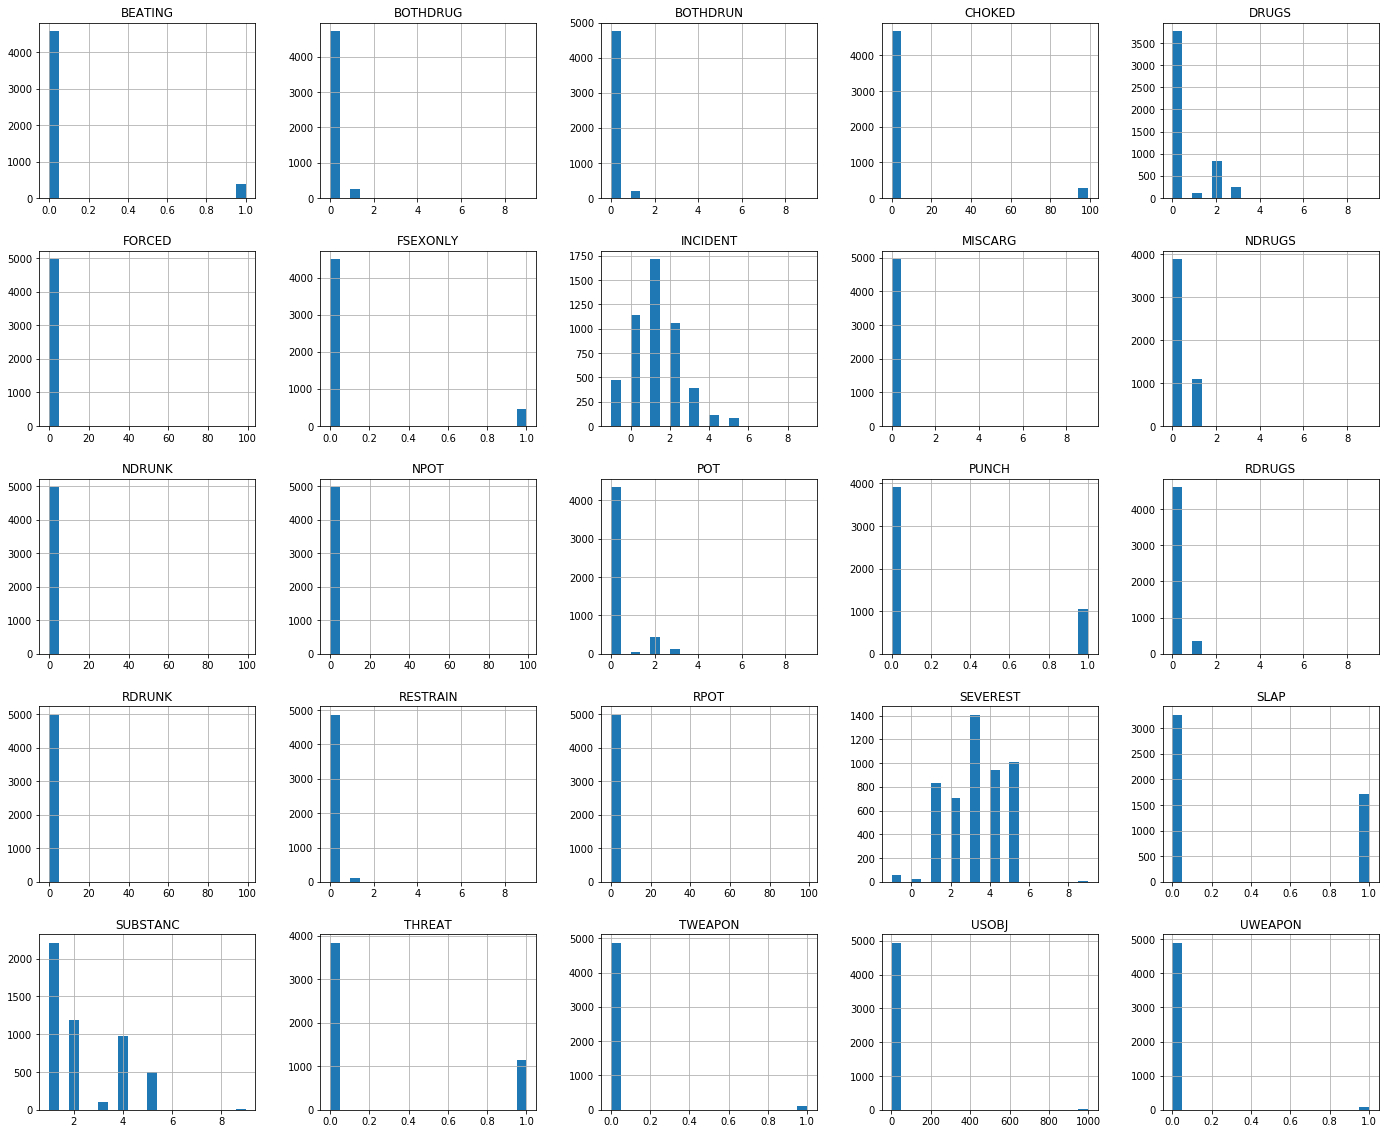

In [13]:
plot_hist(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1dd14e10>,
      dtype=object)

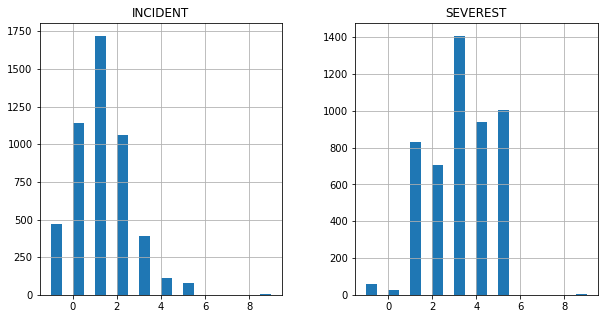

In [14]:
df[['INCIDENT','SEVEREST']].hist(figsize=(10, 5), bins=20)

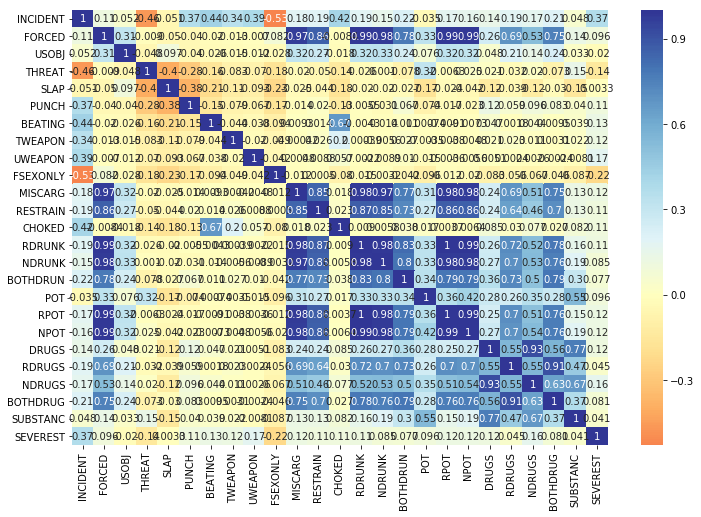

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='RdYlBu', annot=True, center=0)

In [16]:
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols

['INCIDENT',
 'FORCED',
 'USOBJ',
 'THREAT',
 'SLAP',
 'PUNCH',
 'BEATING',
 'TWEAPON',
 'UWEAPON',
 'FSEXONLY',
 'MISCARG',
 'RESTRAIN',
 'CHOKED',
 'RDRUNK',
 'NDRUNK',
 'BOTHDRUN',
 'POT',
 'RPOT',
 'NPOT',
 'DRUGS',
 'RDRUGS',
 'NDRUGS',
 'BOTHDRUG',
 'SUBSTANC',
 'SEVEREST']

In [17]:
df_xgb_x = df[num_cols].drop(columns=['CHOKED'])

In [18]:
fn = df_xgb_x.columns.values

/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


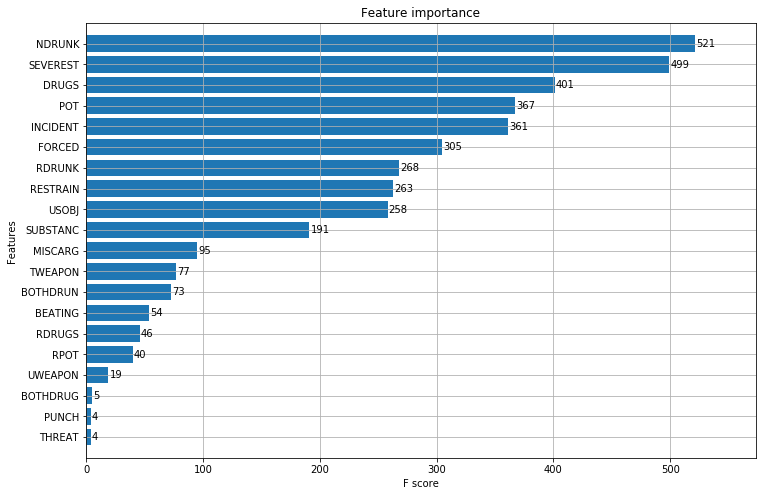

In [19]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(df_xgb_x, df.CHOKED, feature_names=fn)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [20]:
X = df[num_cols].drop(columns=['CHOKED'])
y = df[['CHOKED']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

X_train.head()

,INCIDENT,FORCED,USOBJ,THREAT,SLAP,PUNCH,BEATING,TWEAPON,UWEAPON,FSEXONLY,...,BOTHDRUN,POT,RPOT,NPOT,DRUGS,RDRUGS,NDRUGS,BOTHDRUG,SUBSTANC,SEVEREST
3511,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,3
3646,1,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,4
749,1,0,2,0,1,0,0,0,0,0,...,1,2,0,1,0,0,0,0,5,1
2756,3,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,5
275,1,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4


In [21]:
# from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 493, solver='saga')

In [22]:
logit.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packag

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=493, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-6.45165409e-03 -5.66950426e-03  3.26472593e-03  4.18493061e-02
   6.45170012e-02  3.66611864e-02 -3.29695910e-02 -4.81395494e-03
  -7.07125421e-04  1.91069265e-02 -3.60805390e-03 -2.92039653e-03
  -3.61290747e-02  8.43359188e-03 -1.77667349e-03  1.82264167e-02
  -3.52767352e-02 -2.89905338e-02  2.83732181e-02  1.79453092e-03
   9.60845431e-03 -1.54375537e-04  2.23843245e-01  2.89887472e-01]
 [-6.95285000e-02 -2.67308525e-02 -2.39262180e-01 -3.26193523e-02
  -4.94430831e-02 -2.71376472e-02  5.77764565e-03  4.87248286e-04
  -9.58670178e-05 -1.53875372e-02 -3.41302089e-04 -1.34560044e-03
  -4.21495934e-03 -4.46643141e-02 -3.19560611e-03 -2.19398643e-02
  -2.97501339e-03 -9.48650042e-03 -4.23634627e-02 -6.49078412e-03
  -1.77846161e-02 -4.11365987e-03 -2.35856200e-01 -3.04255868e-01]
 [-1.36336136e-01  1.43567343e-02 -2.17985802e-03 -3.55042109e-02
  -5.26998636e-02 -2.77561760e-02 -1.06626176e-02 -2.31490552e-03
  -1.73909691e-03 -1.76973796e-02  3.77232886e-03  1.096910

In [24]:
y_pred = logit.predict(X_train)

In [25]:
y_pred_proba = logit.predict_proba(X_train)

In [26]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.93


In [27]:
print(confusion_matrix(y_train, y_pred))

[[3223    0    2    0]
 [  56    0    0    0]
 [   0    0    4    0]
 [ 199    0    0    0]]


In [28]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3225
           1       0.00      0.00      0.00        56
           9       0.67      1.00      0.80         4
          99       0.00      0.00      0.00       199

   micro avg       0.93      0.93      0.93      3484
   macro avg       0.40      0.50      0.44      3484
weighted avg       0.86      0.93      0.89      3484



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on test set: 0.93


In [32]:
df.NDRUNK.value_counts()

0     2984
1     1990
99       4
Name: NDRUNK, dtype: int64